# Futbolistas Argentinos AXEM
## Limpieza del dataset de Fubolistas Argentinos por el mundo

### ¿Qué es Futbolistas Argentinos AXEM?

Futbolistas Argentinos AXEM se encarga de hacer el seguimiento de la carrera de más de 2500 futbolistas argentinos por el mundo. En Diciembre de 2018 publicaron oficialmente la edición N°28 del archivo de Argentinos por el Mundo, con la que se trabajará a continuación.

Cuentas oficiales de AXEM: [Web](http://futbolistasaxem.com.ar/) - [Facebook](https://www.facebook.com/FutbolistasAXEM/) - [Twitter](https://twitter.com/FutbolistasAXEM)

### Objetivo
El objetivo del proyecto es *limpiar* y *transformar* el dataset de AXEM para que quede en un formato más apropiado para trabajarlo.

### Datos de entrada
En este proyecto se trabajará con el Excel de la edición N°28 de AXEM y con un CSV con códigos y nombres de países, que ayudará en la normalización.

*  [Archivo AXEM - Diciembre 2018](https://wetransfer.com/downloads/d75712ef256560fe86403e97cce269d020181219165022/3f3ec4?fbclid=IwAR1JiFmmlJPkEOvVZOH3VviGhy16ZsiPN_hJvMjtsfezT_ogMzlWkuRu-NU) - [Publicación oficial en Facebook](https://www.facebook.com/notes/futbolistas-argentinos-axem/archivo-axem-diciembre-2018/2307096119567319/)
    * Descripción: archivo *.xlsx* con información de futbolistas, integrantes de cuerpos técnicos y dirigentes argentinos en el fútbol mundial. Se utilizan sólo las hojas con datos de futbolistas hombres en las 6 confederaciones FIFA (**2621 jugadores**). De cada futbolista se conoce: **liga** y **equipo** en el que juega actualmente; **nombre**; **lugar** y **fecha de nacimiento**; **puesto** y **trayectoria**.
    ![axem_2018_preview.JPG](data/images/axem_2018_preview.JPG)
*  [Nombres y códigos de países](https://github.com/datasets/country-codes)
    * Descripción: archivo *.csv* con nombres y códigos de países. Sólo se utilizan las columnas: **ISO3166-1-Alpha-3**, **ISO3166-1-Alpha-2**, **official_name_es** y **Region Name**.
    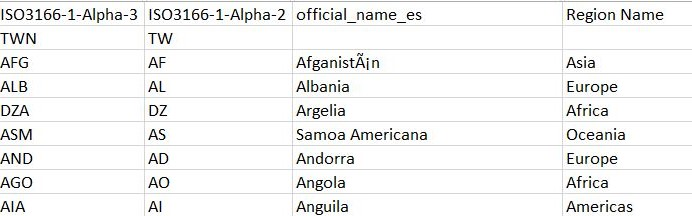
    
### Datos de salida
*  */data/output/axem_2018_processed.csv*: archivo .csv con los jugadores argentinos por el mundo. Cada fila corresponde a un jugador.
*  */data/output/trayectorias.csv*: archivo .csv con la trayectoria de los jugadores. Cada fila representa el paso de un jugador por un equipo.

In [1]:
# Imports
import pandas as pd
import yaml
import re
import numpy as np
import unicodedata
import stringdist as sd
from IPython.display import display, Markdown as md

#### Archivos de entrada
  * En *config* guarda los datos del archivo *axem_wrangling.yml* que tiene información de configuración del proyecto (parámetros para leer y escribir los archivos, configuración general)
  * En *axem_dfs* guarda una lista de DataFrames. Cada DataFrame contiene una hoja del Excel.
  * En *paises_df* guarda un DataFrame con información de países, para aplicar luego en la normalización.

In [2]:
config = yaml.safe_load(open("axem_wrangling.yml", encoding="utf-8"))
axem_dfs = pd.read_excel(**config["input"]["axem"])
paises_df = pd.read_csv(**config["input"]["paises"])

### Limpieza y transformación de *paises_df*

In [3]:
paises_df.columns = ["iso_3", "iso_2", "nombre_oficial", "continente"] # Renombra las columnas

def elimina_tildes(s):
    s = ''.join((c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn'))
    return s

# Elimina tildes para simplificar comparaciones
paises_df["nombre_oficial"] = paises_df["nombre_oficial"].apply(lambda x: elimina_tildes(str(x)).upper())

# Borra palabras entre paréntesis (ejemplo: 'Venezuela (República Bolivariana de)')
paises_df["nombre_oficial"] = paises_df["nombre_oficial"].apply(lambda x: re.sub("\s\(.+\)", "", str(x)))

# Crea nuevas columnas 'iniciales_3' e 'iniciales_4' que luego servirán para comparaciones con abreviaturas de los países
paises_df["iniciales_3"] = paises_df["nombre_oficial"].apply(lambda x: x[0:3].upper())
paises_df["iniciales_4"] = paises_df["nombre_oficial"].apply(lambda x: x[0:4].upper())

display(paises_df.head())

,iso_3,iso_2,nombre_oficial,continente,iniciales_3,iniciales_4
0,TWN,TW,NAN,NaN,NAN,NAN
1,AFG,AF,AFGANISTAN,Asia,AFG,AFGA
2,ALB,AL,ALBANIA,Europe,ALB,ALBA
3,DZA,DZ,ARGELIA,Africa,ARG,ARGE
4,ASM,AS,SAMOA AMERICANA,Oceania,SAM,SAMO


### Limpieza y transformación de *axem_dfs*

In [4]:
axem_df = pd.concat(axem_dfs) # Concatena todos los DataFrames en uno sólo

axem_df.reset_index(inplace=True) # Resetea el índice. En los campos 'level_0' y 'level_1' quedan los índices anteriores.

axem_df.drop(["delete", "level_1"], axis="columns", inplace=True)

display(md("La lectura del archivo *.xlsx* en un DataFrame no es precisa. Quedan muchas filas sin datos, como se puede \
           ver a continuación:"))
display(axem_df.head())
display(md("El DataFrame debería tener **2621** filas (una por cada jugador). Actualmente tiene **{0}**.".format(axem_df.shape[0])))

La lectura del archivo *.xlsx* en un DataFrame no es precisa. Quedan muchas filas sin datos, como se puede            ver a continuación:

,level_0,division,equipo,nombre,nacimiento,puesto,trayectoria
0,M-AFC,NaN,NaN,NaN,NaN,NaN,NaN
1,M-AFC,NaN,NaN,NaN,NaN,NaN,NaN
2,M-AFC,Div,Equipo,Nombre,Lugar Nacimiento (Fecha),Puesto,Trayectoria
3,M-AFC,1ª - Professional League,Al Ettifaq,Cristian David Guanca,"Don Torcuato, Buenos Aires (27/03/93)",DEL,* Chacarita; Colon Santa Fe; Emelec (Ecu); Kas...
4,M-AFC,NaN,Al Feiha,Jonathan David Gomez,"Capitan Bermudez, Santa Fe (21/12/89)",VOL,* Rosario Central; Banfield; Murcia (Esp); Ars...


El DataFrame debería tener **2621** filas (una por cada jugador). Actualmente tiene **3141**.

#### Columna: *confederacion*

In [5]:
axem_df.rename({"level_0": "confederacion"}, axis="columns", inplace=True) # Renombra 'level_0' a 'confederacion'
axem_df.loc[:, "confederacion"] = axem_df["confederacion"].apply(lambda x: x.replace("M-", "")) # Limpia los valores

display(md("Confederaciones FIFA:"))
display(axem_df["confederacion"].unique())

Confederaciones FIFA:

array(['AFC', 'CAF', 'CONCACAF', 'CONMEBOL', 'OFC', 'UEFA'], dtype=object)

#### Columna: *pais*
Como se puede ver en la imagen del archivo de Excel, el nombre de los países ocupa todo una fila, y no siempre está escrito en la misma columna.

In [6]:
def get_pais(row):
    """ Busca en en las columnas 'division', 'equipo' y 'nombre' el nombre de algún pais.
    Si está escrito en mayúsculas, se considera un país"""
    columnas_con_paises = ["division", "equipo", "nombre"]

    for col in columnas_con_paises:
        if re.sub("\.", "", str(row[col]).strip()).isupper():
            return row[col].strip()

    return None

axem_df["pais"] = axem_df.apply(get_pais, axis=1) # Para cada fila, busca si en alguna columna está el nombre de un país

# Hay algunos equipos con nombres en mayúsculas que se los confunde con países
axem_df["pais"].replace(config["pais_exceptions"], value=np.nan, inplace=True)

 # Completa las celdas vacías en 'pais' con el valor de la inmediata anterior que no es NaN
axem_df["pais"].fillna(method="ffill", inplace=True)

axem_df["pais"].fillna("ARABIA SAUDITA", inplace=True) # Las que quedan vacías corresponden a Arabia Saudita

display(axem_df.head())

,confederacion,division,equipo,nombre,nacimiento,puesto,trayectoria,pais
0,AFC,NaN,NaN,NaN,NaN,NaN,NaN,ARABIA SAUDITA
1,AFC,NaN,NaN,NaN,NaN,NaN,NaN,ARABIA SAUDITA
2,AFC,Div,Equipo,Nombre,Lugar Nacimiento (Fecha),Puesto,Trayectoria,ARABIA SAUDITA
3,AFC,1ª - Professional League,Al Ettifaq,Cristian David Guanca,"Don Torcuato, Buenos Aires (27/03/93)",DEL,* Chacarita; Colon Santa Fe; Emelec (Ecu); Kas...,ARABIA SAUDITA
4,AFC,NaN,Al Feiha,Jonathan David Gomez,"Capitan Bermudez, Santa Fe (21/12/89)",VOL,* Rosario Central; Banfield; Murcia (Esp); Ars...,ARABIA SAUDITA


#### Columna: *continente*

In [7]:
# Crea la columna continente en base a la confederación
axem_df["continente"] = axem_df["confederacion"].map(config["confederacion_continente"])

display(axem_df.sample(3).loc[:, ["confederacion", "pais", "continente"]])

,confederacion,pais,continente
474,CONCACAF,EE.UU.,Americas
1714,UEFA,ESPAÑA,Europe
139,AFC,QATAR,Asia


#### Columna: *iso_3*
Se intenta identificar unívocamente a los países con los códigos de 3 caracteres *ISO 3166-1 alfa-3* [(Wikipedia)](https://es.wikipedia.org/wiki/ISO_3166-1)

In [8]:
def get_iso_3(pais, continente, paises_df):
    """ Devuelve el código 'iso_3' para 'pais' """
    pais_iniciales_3 = pais[0:3]
    paises_df_subset = paises_df.query("continente == @continente").copy()
    
    # Primero busca coincidencia de las 3 primeras letras. Si no hay coincidencia, busca por Distancia de Levenshtein.
    if  sum(paises_df_subset["iniciales_3"] == pais_iniciales_3) > 0:
        return paises_df_subset.query("iniciales_3 == @pais_iniciales_3").iloc[0]["iso_3"]
    else:
        paises_df_subset.loc[:, "dist"] = paises_df_subset["nombre_oficial"].apply(lambda x: sd.levenshtein(x, pais))
        return paises_df_subset.loc[paises_df_subset["dist"].idxmin()]["iso_3"]
    
pais_iso_3_tabla_match = dict()
paises_axem_df = axem_df.loc[:, ["pais", "continente"]].copy().drop_duplicates()

for index, row in paises_axem_df.iterrows():
    if row["pais"] in config["name_exceptions"]:
        pais_iso_3_tabla_match[row["pais"]] = config["name_exceptions"][row["pais"]]
    else:
        pais_iso_3_tabla_match[row["pais"]] = get_iso_3(row["pais"], row["continente"], paises_df)

axem_df["pais_iso_3"] = axem_df["pais"].apply(lambda x: pais_iso_3_tabla_match[x])

display(axem_df.sample(3).loc[:, ["pais", "continente", "pais_iso_3"]])

,pais,continente,pais_iso_3
279,EE.UU.,Americas,USA
218,CANADA,Americas,CAN
1553,ESLOVENIA,Europe,SVN


#### Columnas: *division*, *categoria* y *liga*
La intención es separar la *categoria* (número) del nombre de la *liga*. 
Por ejemplo:
  * *division*: 2°- Victoria National Premier League
    * *categoria*: 2
    * *liga*: Victoria National Premier League

In [9]:
axem_df["division"].fillna(method="ffill", inplace=True) # Completa los NaN


def get_categoria_liga(s):
    """ Devuelve la categoria y el nombre de la liga """
    regex_match = re.search("([0-9]+)\s?[°|ª]\s?-?\s?(.+)", str(s))
    if regex_match is not None:
        return regex_match.group(1), regex_match.group(2)
    else:
        return None, s

# Agrega las columnas 'categoria' y 'liga'
axem_df["categoria"], axem_df["liga"] = zip(*axem_df["division"].map(get_categoria_liga))

display(axem_df.sample(3).loc[: , ["division", "categoria", "liga"]])

,division,categoria,liga
1435,2° - Segona Diviso,2,Segona Diviso
440,Universitario,None,Universitario
2037,7° Catalunya - Tercera/15,7,Catalunya - Tercera/15


#### Columna: *equipo*
Cuando más de un jugador pertenece al mismo equipo, sólo se indica el equipo en el primer jugador de la lista. Los que están por debajo tienen el campo vacío. Se completa a continuación.

In [10]:
axem_df["equipo"].fillna(method="ffill", inplace=True) # Completa los vacíos
axem_df = axem_df[axem_df["equipo"] != "TOTAL"] # Borra las filas que tienen 'TOTAL' en 'equipo'

#### Columna: *nombre*

In [11]:
axem_df.dropna(subset=["nombre"], inplace=True) # Borra las filas que no tienen *nombre*
axem_df["nombre"] = axem_df["nombre"].apply(lambda x: str(x).strip()) # Borra espacios en blanco
axem_df = axem_df[(axem_df["nombre"] != "Nombre") & (axem_df["nombre"] != "MALASIA")]

display(md("El DataFrame ya tiene la cantidad de filas correctas: **{0}**".format(axem_df.shape[0])))

El DataFrame ya tiene la cantidad de filas correctas: **2621**

#### Columnas: *ciudad_nacimiento* y *fecha_nacimiento*
Separa la ciudad y fecha de nacimiento en dos columnas distinas

In [12]:
def get_datos_nacimiento(s):
    """ Devuelve la ciudad y fecha de nacimiento """
    regex_match = re.search("(.+)?\s?\\((.+)\\)", str(s))
    if regex_match is not None:
        return regex_match.group(1), regex_match.group(2)
    else:
        return None, None

axem_df["ciudad_nacimiento"], axem_df["fecha_nacimiento"] = zip(*axem_df["nacimiento"].map(get_datos_nacimiento))
axem_df.loc[:, "fecha_nacimiento"] = axem_df["fecha_nacimiento"].apply(lambda x: None if (x is None or "?" in x) else x)
axem_df.loc[:, "fecha_nacimiento"] = pd.to_datetime(axem_df["fecha_nacimiento"], infer_datetime_format=True, errors="coerce")

# Borra las fechas de nacimiento posteriores al 01/01/2006
outliers = axem_df.loc[:, "fecha_nacimiento"] > pd.Timestamp('2006-01-01')
axem_df.loc[outliers, "fecha_nacimiento"] = None

display(axem_df.sample(3).loc[:, ["nacimiento", "ciudad_nacimiento", "fecha_nacimiento"]])

,nacimiento,ciudad_nacimiento,fecha_nacimiento
2281,???,None,NaT
1794,"Resistencia, Chaco (??/??/99)","Resistencia, Chaco",NaT
333,Ciudad de Cordoba,None,NaT


#### Columna: *puesto*

In [13]:
axem_df["puesto"].replace({"?": np.nan}, inplace=True) # Reemplaza '?' por NaN

#### Columna: *trayectoria*

In [14]:
axem_df["trayectoria"].replace(["* ???", "*  ???"], value=np.nan, inplace=True) # Reemplaza '* ???' y '*  ???' por NaN


def get_iso_3_codigo(codigo_pais, paises_df):
    """ Devuelve el iso_3 para 'codigo_pais' """
    try:
        if codigo_pais in config["code_exceptions"]:
            iso_3 = config["code_exceptions"][codigo_pais]
        elif len(codigo_pais) == 2:
            iso_3 = paises_df.query("iso_2 == @codigo_pais").iloc[0]["iso_3"]
        elif len(codigo_pais) == 3:
            iso_3 = paises_df.query("iso_3 == @codigo_pais | iniciales_3 == @codigo_pais").iloc[0]["iso_3"]
        else:
            iso_3 = paises_df.query("iniciales_4 == @codigo_pais").iloc[0]["iso_3"]
    except IndexError:
        iso_3 = "SD"

    return iso_3


def get_trayectoria(trayectoria, paises_df):
    """ Devuelve la trayectoria en una lista y con los códigos de países normalizados """
    if trayectoria is None or trayectoria is np.nan:
        return None

    trayectoria = str(trayectoria).replace("* ", "")

    # Lista con los clubes de la trayectoria
    clubes = re.split(";|,|:|(?<=\))\s(?=\w)|(?<=\])\s(?=\w)", trayectoria)

    trayectoria_norm = list()   # Lista donde guarda la trayectoria normalizada
    for club in clubes:
        if club == "":
            continue

        club = re.sub("\[di\]|\(di\)", "", club).strip()  # Borra los indicadores de divisiones inferiores

        codigo_pais_match = re.search("\((.+)\)", club)
        if codigo_pais_match is None:
            iso_3 = "ARG"   # Si no indica el código de páis, el equipo es de Argentina
        else:
            club = re.sub("[\[|\(].+[\]|\)]", "", club).strip() # Borra lo que hay dentro de paréntesis o corchetes
            codigo_pais = str.upper(codigo_pais_match.group(1))
            iso_3 = get_iso_3_codigo(codigo_pais, paises_df)

        trayectoria_norm.append("{0} ({1})".format(club, iso_3))

    return trayectoria_norm

# Normaliza la columna 'trayectoria'
axem_df["trayectoria"] = axem_df["trayectoria"].apply(lambda x: get_trayectoria(x, paises_df))

display(axem_df.sample(3).loc[:, ["nombre", "trayectoria"]])

,nombre,trayectoria
1434,Angel Ezequiel Marchegiani,"[San Miguel (ARG), Platense (ARG), Juventud Un..."
2631,Lucas Emanuel Cardoso,"[Banfield (ARG), Brown de Adrogue (ARG), Depor..."
2000,Federico Martin Ihitsague,[Atletico Santa Rosa (ARG)]


#### Archivo de *trayectorias*
Se creó un nuevo DataFrame únicamente con la información de la trayectoria de los jugadores, en un formato más amigable.
En este caso, cada fila representa el paso de un jugador por un club. Es decir, si un jugador estuvo en 5 clubes, estará en 5
filas que indican los clubes por los que pasó.

In [15]:
axem_df.reset_index(inplace=True) # Resetea el índice
axem_df.index.name = "id_jugador" # Nombre del nuevo índice de 'axem_df' (cada fila es un jugador)


def get_trayectoria_completa(row):
    " Devuelve el listado de la trayectoria con el equipo actual incluido "
    equipo_actual = row["equipo"] + " (" + row["pais_iso_3"] + ")"
    if row["trayectoria"] is None:
        return [equipo_actual]
    else:
        return row["trayectoria"] + [equipo_actual]

axem_df.loc[:, "trayectoria"] = axem_df.apply(get_trayectoria_completa, axis=1) # Agrega el equipo actual a la trayectoria

# Nuevo DataFrame 'trayectorias_df'
trayectorias_df = axem_df.loc[:, ["nombre"]].copy()
trayectorias_df = axem_df["trayectoria"].apply(pd.Series)\
.merge(trayectorias_df, left_index=True, right_index=True)\
.reset_index()\
.melt(id_vars=["id_jugador", "nombre"], value_name = "equipo", var_name = "orden")\
.dropna(subset=["equipo"])

trayectorias_df.sort_values(by=["id_jugador", "orden"], inplace=True) # Ordena el DataFrame por 'id_jugador' y 'orden'
display(trayectorias_df.head())

,id_jugador,nombre,orden,equipo
0,0,Cristian David Guanca,0,Chacarita (ARG)
2621,0,Cristian David Guanca,1,Colon Santa Fe (ARG)
5242,0,Cristian David Guanca,2,Emelec (ECU)
7863,0,Cristian David Guanca,3,Kasimpasa (TUR)
10484,0,Cristian David Guanca,4,Colon de Santa Fe (ARG)


In [16]:
# Separa en una nueva columna el código de país
trayectorias_df.loc[:, "pais_iso_3"] = trayectorias_df["equipo"].apply(lambda x: re.search("\((.{3})\)", x).group(1))
trayectorias_df.loc[:, "equipo"] = trayectorias_df["equipo"].apply(lambda x: re.sub("\(.{3}\)", "", x).strip())

display(trayectorias_df.head())

,id_jugador,nombre,orden,equipo,pais_iso_3
0,0,Cristian David Guanca,0,Chacarita,ARG
2621,0,Cristian David Guanca,1,Colon Santa Fe,ARG
5242,0,Cristian David Guanca,2,Emelec,ECU
7863,0,Cristian David Guanca,3,Kasimpasa,TUR
10484,0,Cristian David Guanca,4,Colon de Santa Fe,ARG


#### Validación

In [17]:
display(md("La cantidad de filas del DataFrame tienen que ser 2621. Filas: **{0}**".format(axem_df.shape[0])))
display(axem_df["confederacion"].value_counts())

display(md("Fecha de nacimiento del jugador mayor: **{:%d/%m/%Y}**".format(axem_df["fecha_nacimiento"].min())))
display(md("Fecha de nacimiento del jugador menor: **{:%d/%m/%Y}**".format(axem_df["fecha_nacimiento"].max())))

display(md("Puestos de jugadores: **{0}**".format(axem_df["puesto"].unique())))

La cantidad de filas del DataFrame tienen que ser 2621. Filas: **2621**

UEFA        1558
CONMEBOL     521
CONCACAF     414
AFC           68
OFC           58
CAF            2
Name: confederacion, dtype: int64

Fecha de nacimiento del jugador mayor: **28/01/1971**

Fecha de nacimiento del jugador menor: **02/08/2005**

Puestos de jugadores: **['DEL' 'VOL' 'ARQ' nan 'DEF' 'DEL ']**

#### Archivos de salida
Guarda los archivos de salida en formato *CSV* de acuerdo a los parámetros fijados en el archivo de configuración

In [18]:
axem_df.to_csv(**config["output"]["axem"])
trayectorias_df.to_csv(**config["output"]["trayectorias"])